# Neural Network - Classify pictures of food.

`Eric Albert Rocamora`

<table><tr>
    <td><img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/breakfast.jpg" style="width:300px;height:300px;"></td>
    <td><img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/hamburger.jpg" style="width:300px;height:300px;"></td>
    <td><img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/fruits.jpg" style="width:300px;height:300px;"></td>
</tr></table>

In this project (half-oriented by DataHack teacher), we're going to create a neural network capable of viewing an image of some type of food and classifying it automatically. We'll use a repository of images from Kaggle. I'll skip all the steps of importing the repositories and go straight to the action:

## Obtención de datos

In [ ]:
import os

os.environ["KAGGLE_USERNAME"] =
os.environ["KAGGLE_KEY"] =

!kaggle datasets download trolukovich/food11-image-dataset --unzip

 99% 1.07G/1.08G [00:07<00:00, 202MB/s]
100% 1.08G/1.08G [00:08<00:00, 144MB/s]


### Class reduction

In order to make this problem more manageable for the project, we'll focus only on six of the available food classes: Bread, Dairy product, Dessert, Egg, Fried food, and Meat. To do this, the following code is provided, which removes the folders corresponding to images of the other classes from the downloaded data.

In [ ]:
from glob import glob
import os

valid_classes = {"Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat"}
datasets = {TRAINDIR, VALDIR, TESTDIR}

for dataset in datasets:
    for classdir in glob(f"{dataset}/*"):  # Find subfolders with classes
        if classdir.split("/")[-1] not in valid_classes:  # Ignore those in valid_classes
            print(f"Deleting {classdir}...")
            for fname in glob(f"{classdir}/*.jpg"):  # Remove each image file
                os.remove(fname)
            os.rmdir(classdir)  # Remove folder

Deleting /content/validation/Soup...
Deleting /content/validation/Vegetable-Fruit...
Deleting /content/validation/Seafood...
Deleting /content/validation/Rice...
Deleting /content/validation/Noodles-Pasta...
Deleting /content/evaluation/Soup...
Deleting /content/evaluation/Vegetable-Fruit...
Deleting /content/evaluation/Seafood...
Deleting /content/evaluation/Rice...
Deleting /content/evaluation/Noodles-Pasta...
Deleting /content/training/Soup...
Deleting /content/training/Vegetable-Fruit...
Deleting /content/training/Seafood...
Deleting /content/training/Rice...
Deleting /content/training/Noodles-Pasta...


## Processing images from files

This image dataset is large, with high resolution images and each of them having different sizes and aspect ratios. We'll have to do the work of loading and processing the images ourselves.

A convenient way to do all this work is through the Keras function image_dataset_from_directory. This function creates a TensorFlow Dataset object with all the images from a directory, loading them into memory dynamically only when the neural network needs to use them. This function also allows us to specify some very useful preprocessing options.

For example, we can create a Dataset with the data in the training folder:

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = 128
batch_size = 128

train_dataset = image_dataset_from_directory(
    TRAINDIR,
    image_size = (image_size, image_size),
    batch_size = batch_size,
    label_mode = 'categorical'
)

Found 6082 files belonging to 6 classes.


The parameters used to configure the dataset are as follows:

* The **directory** from which to load the images.
* An **image size** (image_size) that will be used to resize all loaded images to that common size, in this case, 128x128 pixels.
* The **batch size** (batch_size) of images to be generated. Note that we define this parameter here instead of in the `fit` step of the network, as we have done in other exercises, because the resulting `Dataset` object will use this information to keep only a few batches of images in memory, thus saving memory.
* The **labeling mode** (label_mode), which is the encoding of the labels to use. `categorical` means that we will use the well-known one-hot encoding.

 A `Dataset` object works very similarly to a Python generator, which means we can iterate over it to get batches of preprocessed images. For example, the following code initiates a loop to extract all batches from the `Dataset`, displays the content of the first one, and stops the iteration.

In [ ]:
for X_batch, y_batch in train_dataset:
    print(f"Shape of input batch: {X_batch.shape}")
    print(f"Shape of output batch: {y_batch.shape}")
    print(f"Input batch:\n{X_batch}")
    print(f"Output batch:\n{y_batch}")
    break

We can see that indeed the generator produces a tensor of input data with appropriate dimensions to feed into the neural network, and the outputs have also been correctly encoded as one-hot.

However, there is still an issue with the data: the pixel values are in the range [0, 255], which can cause training problems. We'll address this later in the neural network definition by using a special layer. For now, let's continue by defining a function that constructs the `Dataset` for the training, validation, and test data.

In [ ]:
def create_datasets(TRAINDIR, VALDIR, TESTDIR, image_size, batch_size):
    train_dataset = image_dataset_from_directory(
    TRAINDIR,
    image_size = (image_size, image_size),
    batch_size = batch_size,
    label_mode = 'categorical'
    )
    val_dataset = image_dataset_from_directory(
    VALDIR,
    image_size = (image_size, image_size),
    batch_size = batch_size,
    label_mode = 'categorical'
    )
    test_dataset = image_dataset_from_directory(
    TESTDIR,
    image_size = (image_size, image_size),
    batch_size = batch_size,
    label_mode = 'categorical'
    )
    return train_dataset, val_dataset, test_dataset

Let's test that the function you implemented works correctly.

In [ ]:
import tensorflow as tf

train_dataset, val_dataset, test_dataset = create_datasets(TRAINDIR, VALDIR, TESTDIR, image_size=128, batch_size=128)

# Test whether all returned objects are valid Tensorflow datasets
assert isinstance(train_dataset, tf.data.Dataset)
assert isinstance(val_dataset, tf.data.Dataset)
assert isinstance(test_dataset, tf.data.Dataset)

Found 6082 files belonging to 6 classes.
Found 2108 files belonging to 6 classes.
Found 2070 files belonging to 6 classes.


Now that we have our Dataset, we can train a deep network with them! As an example, let's build an extremely simple convolutional network. Notice how we added a special preprocessing layer called Rescaling, which will normalize the pixel values to the range [0, 1] each time the network receives an image.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Convolution2D, Rescaling

model = Sequential()
model.add(Rescaling(scale=1./255, input_shape=(image_size, image_size, 3)))
model.add(Convolution2D(4, 3, activation='linear'))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

The `fit` method of a Keras model can receive a `Dataset` object as training data instead of a pair of tensors (inputs, outputs). Since we already specified the batch size when constructing the `Dataset`, it's not necessary to specify it now.

In [ ]:
model.fit(train_dataset, epochs=1)

48/48 [==============================] - 20s 201ms/step - loss: 253645271043696171679744.0000 - accuracy: 0.1960


Similarly, we can evaluate the performance of our model on the test `Dataset` as follows:

In [ ]:
loss, acc = model.evaluate(test_dataset)
print(f"Loss {loss:.3}, accuracy {acc:.1%}")

17/17 [==============================] - 4s 110ms/step - loss: 14993527418169178835648512.0000 - accuracy: 0.1618
Loss 1.5e+25, accuracy 16.2%


This level of accuracy may seem poor, but keep in mind that we've used a very simple model and that the problem involves 6 classes. Let's continue trying to increase that accuracy percentage.

## Building our own network

In [ ]:
from tensorflow.keras.layers import MaxPooling2D

pool_size = 5

model2 = Sequential()
model2.add(Rescaling(scale=1./255, input_shape=(image_size, image_size, 3)))
model2.add(Convolution2D(500, 3, activation='relu'))
model2.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(6, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
model2.fit(train_dataset, epochs=5)

Epoch 1/5
48/48 [==============================] - 35s 642ms/step - loss: 2.3894 - accuracy: 0.2443
Epoch 2/5
48/48 [==============================] - 31s 618ms/step - loss: 1.5270 - accuracy: 0.3624
Epoch 3/5
48/48 [==============================] - 32s 625ms/step - loss: 1.3870 - accuracy: 0.4388
Epoch 4/5
48/48 [==============================] - 32s 627ms/step - loss: 1.2896 - accuracy: 0.4895
Epoch 5/5
48/48 [==============================] - 32s 621ms/step - loss: 1.1718 - accuracy: 0.5427


In [ ]:
loss, acc = model2.evaluate(test_dataset)
print(f"Loss {loss:.3}, accuracy {acc:.1%}")

17/17 [==============================] - 8s 364ms/step - loss: 1.3280 - accuracy: 0.4879
Loss 1.33, accuracy 48.8%


## Transfer learning

Although designing our own network may yield some acceptable results, it's often better to leverage existing knowledge in a pre-trained network. This not only leads to better results but also saves us a lot of time in designing the network. For this purpose, the [Keras Applications](https://keras.io/api/applications/) module contains several pre-designed networks ready for use. For example, to make use of the famous VGG16 network, we do the following:

In [ ]:
from tensorflow.keras.applications import VGG16

vgg16_model = VGG16(include_top=False, input_shape=(image_size, image_size, 3))

58900480/58889256 [==============================] - 0s 0us/step


By default, all networks in Keras Applications come preloaded with weights obtained by training the network on the [ImageNet dataset](http://www.image-net.org/). To adapt the network to our problem, we needed to specify the resolution of our images (`input_shape`) and remove the output layers (`top`) from the original network since we'll have a different number of classes.

Now, how do we transfer the learning from this network? Let's see how to implement the "bottleneck features" strategy. First, we mark the VGG16 model as non-trainable so that its parameters remain frozen.

In [ ]:
vgg16_model.trainable = False

Having done this, let's build a neural network that includes the VGG16 as one of its "layers." It's important to note that the VGG16 network was trained using a very specific normalization of the training images, and we must follow the same process to ensure the network behaves correctly. Conveniently, Keras also provides us with functionality to replicate the normalization that VGG16 requires.

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

We can test this normalization with one of the images from our dataset.

In [ ]:
for X_batch, _ in train_dataset:
    break

print(f"Before normalizing: {X_batch[0, :3, :3, :]}")
print(f"After normalizing: {preprocess_input(X_batch)[0, :3, :3, :]}")

Before normalizing: [[[ 16.25  52.25 114.25]
  [ 17.25  61.   117.25]
  [ 19.25  70.5  131.25]]

 [[ 19.25  56.   108.5 ]
  [ 11.    51.25 102.  ]
  [ 10.25  54.25 109.75]]

 [[ 14.5   47.    89.  ]
  [ 15.75  48.25  92.75]
  [ 23.5   58.5  106.  ]]]
After normalizing: [[[  10.310997  -64.529    -107.43    ]
  [  13.310997  -55.779    -106.43    ]
  [  27.310997  -46.279    -104.43    ]]

 [[   4.560997  -60.779    -104.43    ]
  [  -1.939003  -65.529    -112.68    ]
  [   5.810997  -62.529    -113.43    ]]

 [[ -14.939003  -69.779    -109.18    ]
  [ -11.189003  -68.529    -107.93    ]
  [   2.060997  -58.279    -100.18    ]]]


The normalization performed by VGG16 involves reversing the order of the color channels (RGB -> BGR) and subtracting the mean values across the entire ImageNet dataset for each color channel separately. Fortunately, the `preprocess_input` function we imported does all this work for us. Additionally, we can embed this function as the first layer of our network, serving the role of the `Rescaling` layer we used in the previous section. This is possible thanks to the `Lambda` layer, which allows us to construct a Keras layer based on any TensorFlow function. So, let's start our network design with this layer.

In [ ]:
from tensorflow.keras.layers import Lambda

model = Sequential()
model.add(Lambda(preprocess_input, input_shape=(image_size, image_size, 3)))

After this, we can add the entire VGG16 network as if it were a new layer, followed by our own layers. Below is an example of this design approach, although it's important to note that it's a very simple design that contains some flaws; a real network for transfer learning should have a better design.

In [ ]:
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 49158     
                                                                 
Total params: 14,763,846
Trainable params: 49,158
Non-trainable params: 14,714,688
_________________________________________________________________


Notice how in the model summary, we can see that the entire network has millions of parameters, but since we've frozen all the parts of the network belonging to VGG16, only a few thousand parameters are trainable: those corresponding to the Dense layer we placed at the end.

Now we can compile and train the model in the usual way.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
model.fit(train_dataset, epochs=1)

loss, acc = model.evaluate(test_dataset)
print(f"Loss {loss:.3}, accuracy {acc:.1%}")

17/17 [==============================] - 10s 493ms/step - loss: 187.1107 - accuracy: 0.5783
Loss 1.87e+02, accuracy 57.8%


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model3 = Sequential()
model3.add(Lambda(preprocess_input, input_shape=(image_size, image_size, 3)))

model3.add(vgg16_model)
model3.add(Dense(500, activation ='relu'))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(500, activation = "relu"))
model3.add(Dropout(0.5))
model3.add(Dense(500, activation ='relu'))

model3.add(Dense(6, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model3.fit(train_dataset, epochs=10)

Epoch 1/10
48/48 [==============================] - 18s 319ms/step - loss: 2.7658 - accuracy: 0.4518
Epoch 2/10
48/48 [==============================] - 17s 322ms/step - loss: 0.9331 - accuracy: 0.6570
Epoch 3/10
48/48 [==============================] - 17s 312ms/step - loss: 0.7854 - accuracy: 0.7118
Epoch 4/10
48/48 [==============================] - 17s 314ms/step - loss: 0.6516 - accuracy: 0.7525
Epoch 5/10
48/48 [==============================] - 17s 312ms/step - loss: 0.5740 - accuracy: 0.7938
Epoch 6/10
48/48 [==============================] - 17s 315ms/step - loss: 0.4707 - accuracy: 0.8269
Epoch 7/10
48/48 [==============================] - 17s 322ms/step - loss: 0.3976 - accuracy: 0.8599
Epoch 8/10
48/48 [==============================] - 18s 343ms/step - loss: 0.3324 - accuracy: 0.8805
Epoch 9/10
48/48 [==============================] - 18s 346ms/step - loss: 0.2804 - accuracy: 0.9004
Epoch 10/10
48/48 [==============================] - 17s 327ms/step - loss: 0.2242 - accura

In [ ]:
loss, acc = model3.evaluate(test_dataset)
print(f"Loss {loss:.3}, accuracy {acc:.1%}")

17/17 [==============================] - 8s 334ms/step - loss: 0.7897 - accuracy: 0.7845
Loss 0.79, accuracy 78.5%


## Final resume and results

Below, I present the table with the different tests I have been conducting.. I have found that my model has improved significantly when I introduced two dense layers of 500 and changed the pooling and convolution to GlobalAveragePooling.

I have also been varying between the image size and the batch. I have already changed the default size in the first of the two networks to 64x64, and it wasn't until the last moment that I tried with 128x128, which makes obtaining the results slower, but as we can see, better.

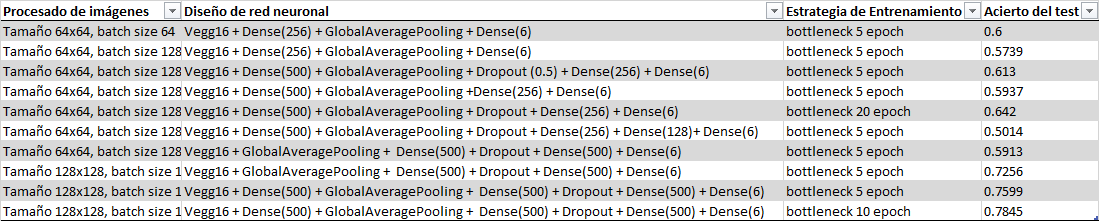
